# TITLE

## Objective
1. Load DICOM CT images and segmentations.
2. Visualize data and check alignment.
3. Create a MIP animation with tumor mask overlay.

In [1]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from skimage.measure import find_contours
from IPython.display import HTML
import pydicom

from utils import (
    load_ct_slices,
    load_segmentation,
    create_mip,
    overlay_mask,
    rotate_volume
)

%matplotlib inline
plt.style.use('grayscale')

In [3]:
# Constants
CT_DIR     = "../dataset/10_AP_Ax2.50mm"
SEG_PATH   = "../dataset/10_AP_Ax2.50mm_ManualROI_Tumor.dcm"
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CT volume and extract z-positions
ct_volume, metadata   = load_ct_slices(CT_DIR)
ct_positions          = metadata['positions']
# Align and load segmentation into 3D mask
mask_volume = load_segmentation(SEG_PATH, ct_positions)

print(f"CT Volume Shape: {ct_volume.shape}   Spacing (mm): {metadata['spacing']}")
print(f"Segmentation Mask Volume Shape: {mask_volume.shape}")

CT Volume Shape: (207, 512, 512)   Spacing (mm): (0.78125, 0.78125, 2.5)
Segmentation Mask Volume Shape: (207, 512, 512)


## Data Verification

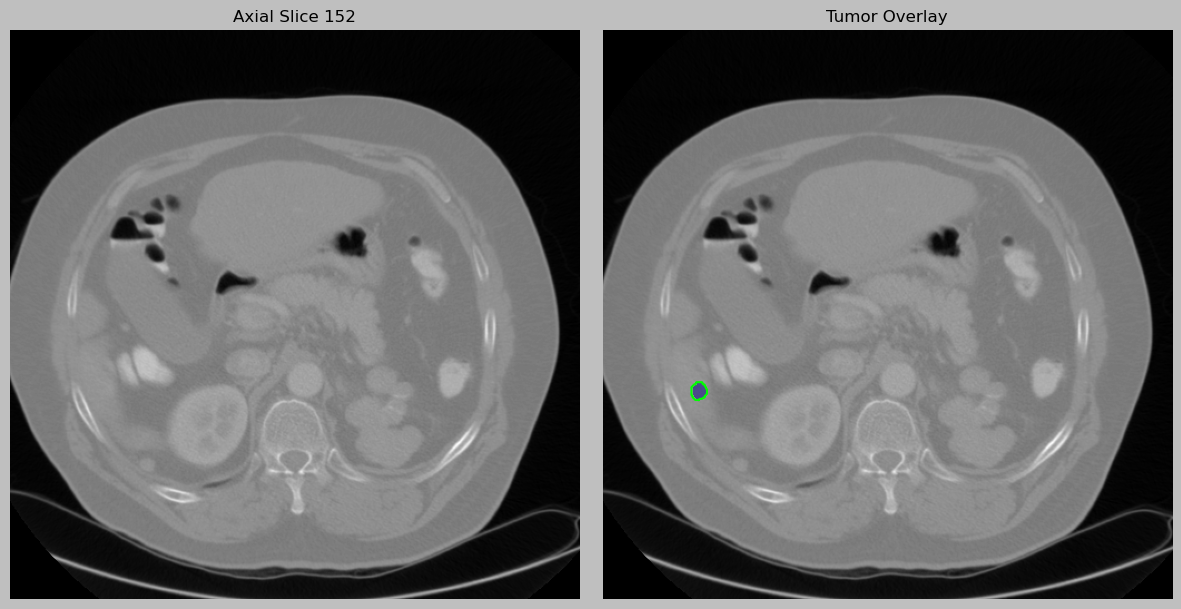

In [4]:
# 1. Scegli la slice con tumore
mask_counts      = mask_volume.sum(axis=(1, 2))
slices_with_tumor= np.where(mask_counts > 0)[0]
slice_idx        = slices_with_tumor[0]

ct_slice   = ct_volume[slice_idx]
mask_slice = mask_volume[slice_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: pure CT
axes[0].imshow(ct_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Axial Slice {slice_idx}")

# Right: CT + SEMI-TRASPARENTE solo ROI + contorni
axes[1].imshow(ct_slice, cmap='gray')

# --- SOLUZIONE 1: masked array ---
masked = np.ma.masked_where(~mask_slice, mask_slice)
axes[1].imshow(ct_slice, cmap='gray')
axes[1].imshow(masked,   cmap='jet', alpha=0.5) 

# disegno i contorni sul True
contours = find_contours(mask_slice, level=0.5)
for cnt in contours:
    axes[1].plot(cnt[:, 1], cnt[:, 0], color='lime', linewidth=1.5)

axes[1].axis('off')
axes[1].set_title("Tumor Overlay")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "slice_overlay.png"))
plt.show()

## Maximum Intensity Projection

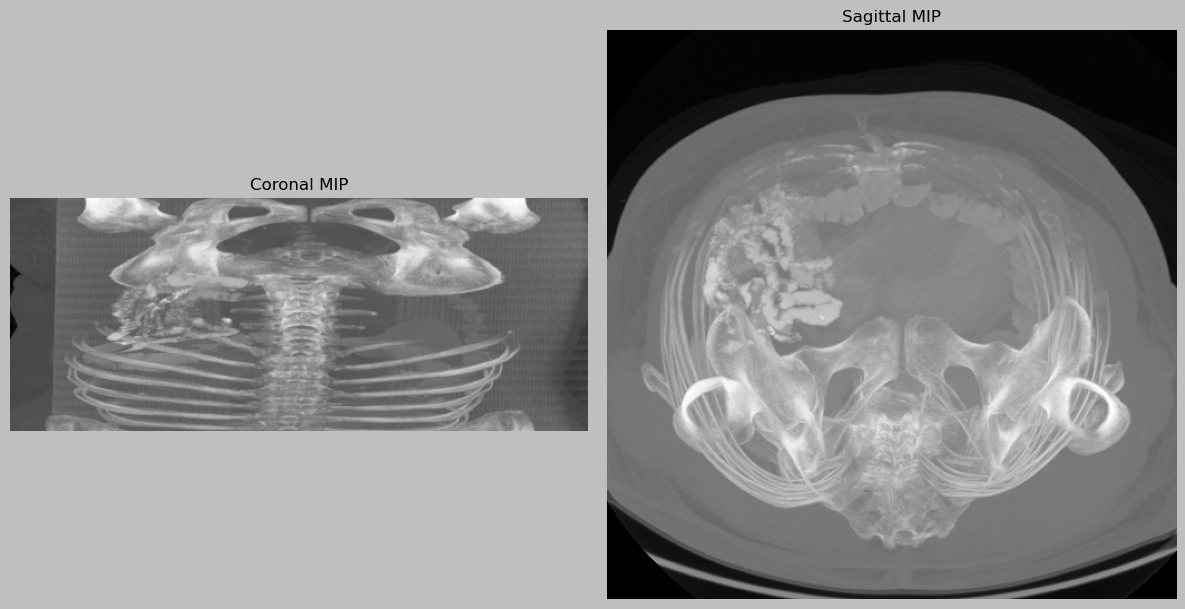

In [5]:
mip_coronal  = create_mip(ct_volume, axis=1)
mip_sagittal = create_mip(ct_volume, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mip_coronal,  cmap='gray'); axes[0].axis('off'); axes[0].set_title("Coronal MIP")
axes[1].imshow(mip_sagittal, cmap='gray'); axes[1].axis('off'); axes[1].set_title("Sagittal MIP")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "mips.png"))
plt.show()

## Rotating MIP Animation

Animation saved at output\mip_rotation.gif
Processing complete.
All outputs in 'output' directory.


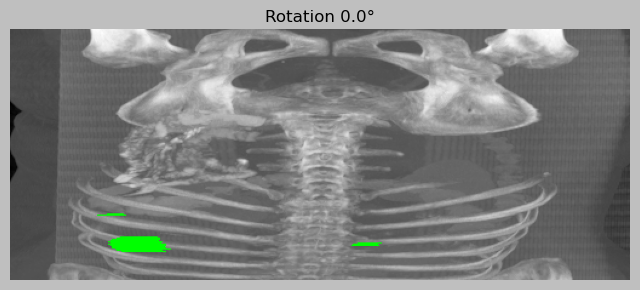

In [6]:
n_frames = 36
fps      = 10
fig_anim = plt.figure(figsize=(8, 8))

def update(frame_idx):
    angle    = 360 * frame_idx / n_frames
    vol_rot  = rotate_volume(ct_volume,    angle, axis='y')
    mask_rot = rotate_volume(mask_volume.astype(np.uint8), angle, axis='y')
    mip_ct   = create_mip(vol_rot,  axis=1)
    mip_mask = create_mip(mask_rot, axis=1)
    frame    = overlay_mask(mip_ct, mip_mask.astype(bool))
    plt.imshow(frame); plt.axis('off'); plt.title(f"Rotation {angle:.1f}°")

anim = FuncAnimation(fig_anim, update, frames=n_frames, blit=False)
gif_path = os.path.join(OUTPUT_DIR, "mip_rotation.gif")
anim.save(gif_path, writer=PillowWriter(fps=fps))
print(f"Animation saved at {gif_path}")

# Display in notebook
HTML(anim.to_jshtml())

print("Processing complete.")
print(f"All outputs in '{OUTPUT_DIR}' directory.")